In [1]:
import pandas as pd
import math as m
from scipy import stats
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn import  metrics
from itertools import product
from sklearn import  metrics
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/vladimir/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/home/vladimir/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
data = pd.read_csv('trade_data.csv', index_col=['DATE'], parse_dates=['DATE'], dayfirst=True)
data.head()

,OPEN,HIGH,LOW,CLOSE,WAP,LTTIME,VALUE,NUMTRADES
DATE,,,,,,,,
2017-07-24,9.11,9.15,8.50,8.55,8.97,NaN,2325011000,37
2017-07-25,9.09,9.10,8.81,8.81,9.02,NaN,3477388000,31
2017-07-26,9.06,9.35,9.05,9.10,9.15,NaN,6537394000,36
2017-07-27,9.17,9.40,9.17,9.25,9.30,NaN,3387899000,26
2017-07-28,9.31,9.32,9.20,9.20,9.26,NaN,4659405000,31


In [3]:
data = pd.concat([data[:'2017-12-27'],data['2018-01-10':] ], axis = 0)

In [4]:
time_series = pd.DataFrame()
time_series['WAP'] = data.WAP[:-1]

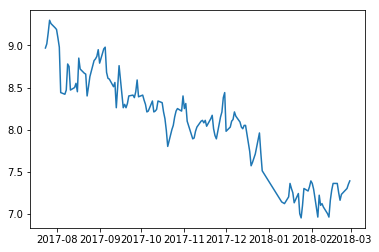

In [5]:
plt.plot(time_series.index, time_series)

виден тренд

## Попробуем предсказать следующие значение по прошлым с помощью SARIMA

Text(0.5,0,'day')

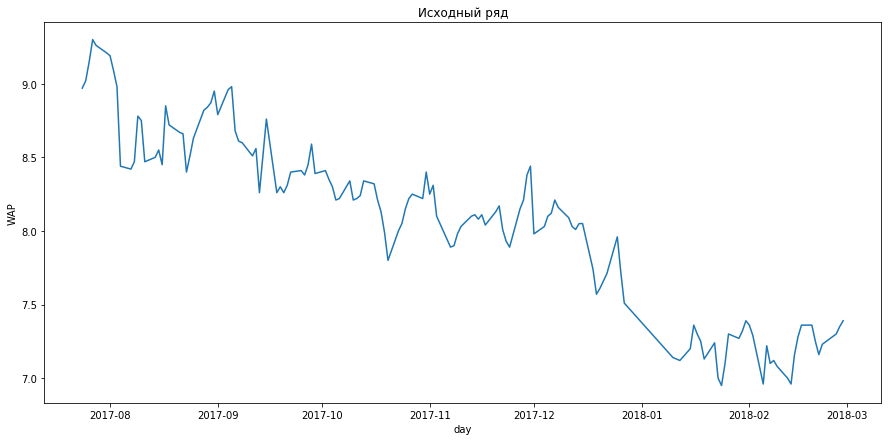

In [6]:
plt.figure(figsize(15,7))
plt.plot(time_series.WAP)
plt.title('Исходный ряд')
plt.ylabel('WAP')
plt.xlabel('day')

Виден понижающийся тренд, также видна автокоррелированость, это можно прогнозировать

In [7]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(time_series.WAP)[1])

Критерий Дики-Фуллера: p=0.523081


Попытаемся Стабилизировать дисперсию с помощью преобразования Бокса-Кокса

Оптимальный параметр преобразования Бокса-Кокса: 2.219704
Критерий Дики-Фуллера: p=0.426798


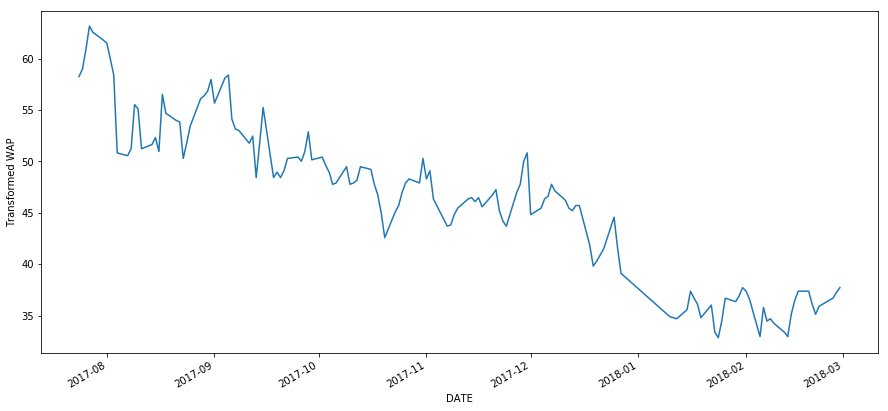

In [8]:
time_series['WAP_box'] , lmbda = stats.boxcox(time_series.WAP)
plt.figure(figsize(15,7))
time_series.WAP_box.plot()
plt.ylabel(u'Transformed WAP')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(time_series.WAP_box)[1])

Попытаемся Сделать ряд стационарным с помощью дифференцирования

Критерий Дики-Фуллера: p=0.000000


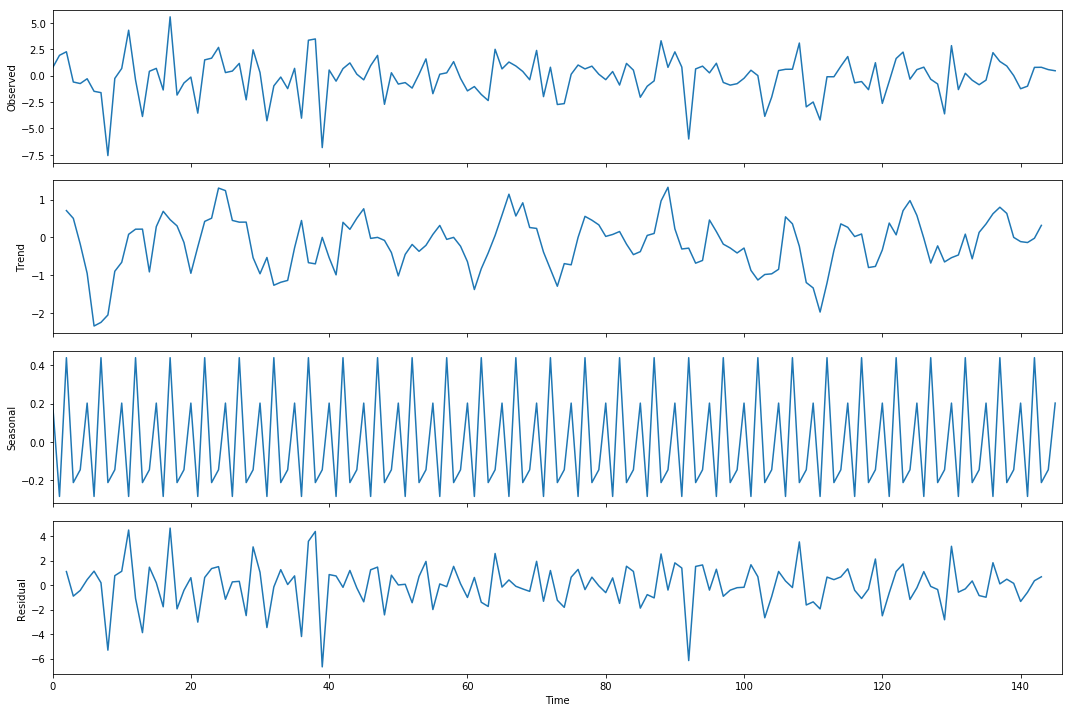

In [9]:
time_series['WAP_box_diff'] = time_series.WAP_box - time_series.WAP_box.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(time_series.WAP_box_diff.values[1:], freq=5).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(time_series.WAP_box_diff.values[1:])[1])

### Подбор модели

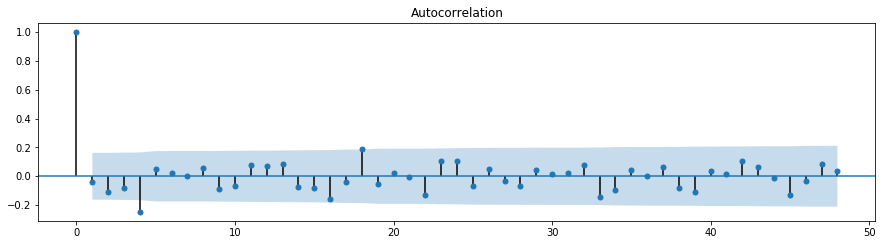

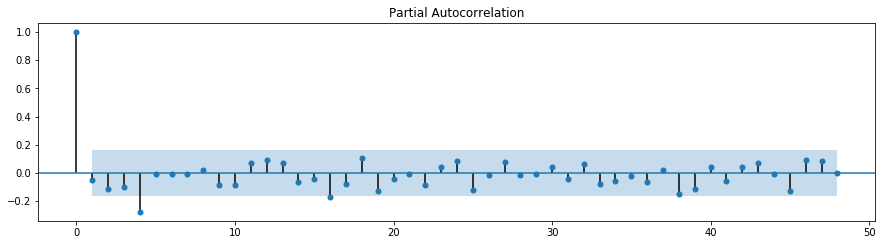

In [10]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(time_series.WAP_box_diff.values[1:], lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(time_series.WAP_box_diff.values[5:], lags=48, ax=ax)
pylab.show()

In [17]:
from itertools import product
ps = range(5, 8)
d=1
qs = range(5, 8)
Ps = range(1, 3)
D=0
Qs = range(1, 3)
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [18]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(time_series.WAP_box.values, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 5)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (5, 6, 1, 1)
wrong parameters: (5, 6, 1, 2)
wrong parameters: (5, 6, 2, 1)
wrong parameters: (5, 6, 2, 2)
wrong parameters: (6, 5, 1, 1)
wrong parameters: (6, 5, 1, 2)
wrong parameters: (6, 5, 2, 1)
wrong parameters: (6, 5, 2, 2)
wrong parameters: (6, 6, 1, 1)
wrong parameters: (6, 6, 1, 2)
wrong parameters: (6, 6, 2, 1)
wrong parameters: (6, 6, 2, 2)
wrong parameters: (7, 5, 1, 1)
wrong parameters: (7, 5, 1, 2)
wrong parameters: (7, 5, 2, 1)
wrong parameters: (7, 5, 2, 2)
wrong parameters: (7, 6, 1, 1)
wrong parameters: (7, 6, 1, 2)
wrong parameters: (7, 6, 2, 1)
wrong parameters: (7, 6, 2, 2)
wrong parameters: (7, 7, 1, 1)
wrong parameters: (7, 7, 1, 2)
wrong parameters: (7, 7, 2, 1)
wrong parameters: (7, 7, 2, 2)
CPU times: user 24.6 s, sys: 260 ms, total: 24.8 s
Wall time: 16.8 s


In [21]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic').head())

     parameters         aic
0  (5, 5, 1, 1)  611.662366
1  (5, 5, 1, 2)  614.146335
4  (5, 7, 1, 1)  614.393527
2  (5, 5, 2, 1)  614.624816
3  (5, 5, 2, 2)  616.069538


In [22]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                  147
Model:             SARIMAX(5, 1, 5)x(1, 0, 1, 5)   Log Likelihood                -292.831
Date:                           Mon, 02 Apr 2018   AIC                            611.662
Time:                                   11:13:36   BIC                            650.538
Sample:                                        0   HQIC                           627.458
                                           - 147                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3038      0.220     -1.378      0.168      -0.736       0.128
ar.L2         -0.0908      0.283     -0.320

Рассмотрим остатки модели

Критерий Стьюдента: p=0.090725
Критерий Дики-Фуллера: p=0.000000


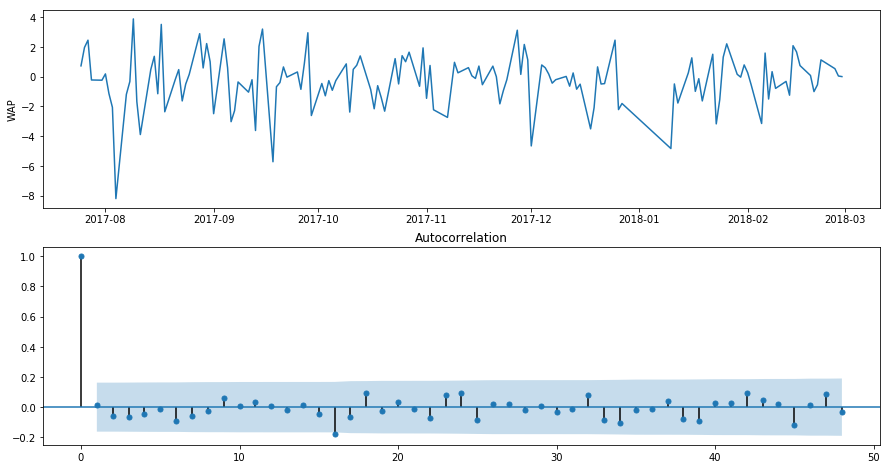

In [23]:
plt.figure(figsize(15,8))
plt.subplot(211)
plt.plot(time_series.index.values[1:], best_model.resid[1:])
#best_model.resid[5:].plot()
plt.ylabel(u'WAP')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[1:], lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[1:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[1:])[1])

Остатки стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).

Вопрос: смещены ли остатки? (критерием Стьюдента не дает ответа)

In [24]:
#В питоне почему-то нет функции обратного преобразования Бокса-Кокса
def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

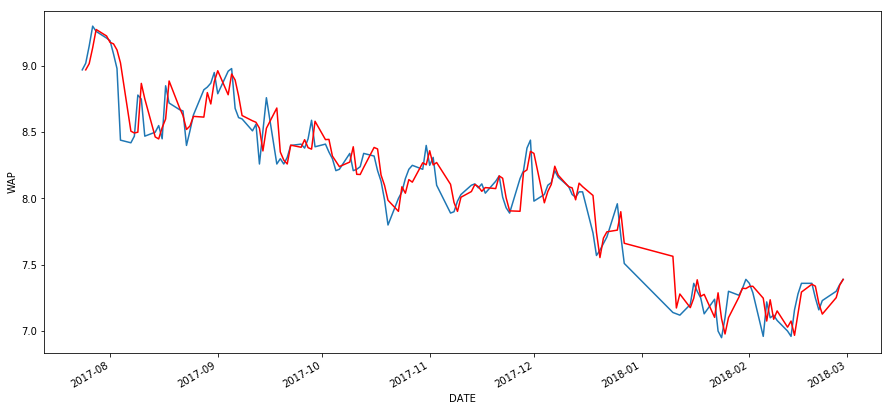

In [25]:
time_series['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
time_series.WAP.plot()
plt.plot(time_series.index.values[1:], time_series.model.values[1:], color='r')
#GDP.model[5:].plot(color='r')
plt.ylabel('WAP')
pylab.show()

Видим запаздывающий тренд

### Прогноз

In [26]:
data.index[-1]

Timestamp('2018-03-01 00:00:00')

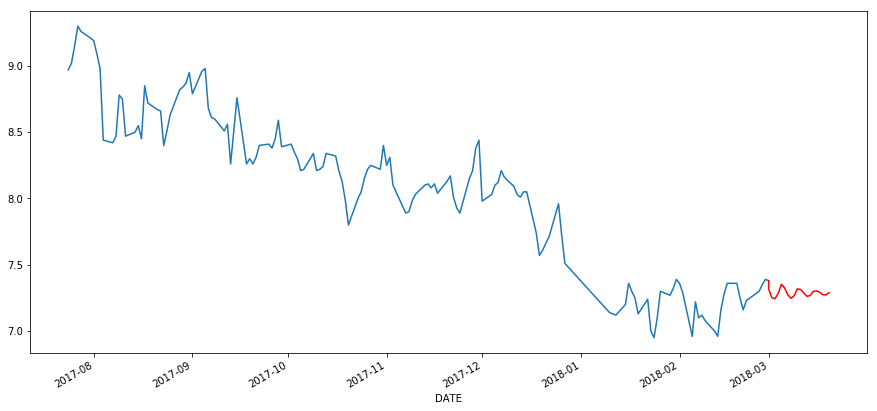

In [27]:
data2 = data[['WAP']]
date_list = [datetime.datetime.strptime("2018-03-01", "%Y-%m-%d") + relativedelta(days=x) for x in range(0,20)]
future = pd.DataFrame(index=date_list, columns= data2.columns)
start = len(best_model.fittedvalues)
future.WAP = invboxcox( best_model.predict(start=start, end=start+19), lmbda)
data2 = pd.concat([data2, future])


plt.figure(figsize(15,7))
data.WAP.plot()
data2.WAP["2018-03-01":].plot(color='r')
pylab.show()

In [28]:
ansver_reg = pd.DataFrame()
ansver = []
for i in future.values:
    ansver.append(i[0])

ansver_reg['ansver'] = ansver
ansver_reg.to_csv("answer.csv")

интересный вариант

In [342]:
param = (5, 5, 1, 1)
d = 1
D = 0
best_model = sm.tsa.statespace.SARIMAX(time_series.WAP_box.values, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 5)).fit(disp=-1)

/home/vladimir/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1042: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
/home/vladimir/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


_____________________
Лучший вариант, но вырожденный вариант

In [250]:
param = (0, 4, 0, 0) 
d = 1
D = 0
best_model = sm.tsa.statespace.SARIMAX(time_series.WAP_box.values, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 5)).fit(disp=-1)

/home/vladimir/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1042: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


_______________---